In [13]:
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
DATA_PATH = "../data/union/End"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "dataset_final.csv")
    return pd.read_csv(csv_path)

In [15]:
df = load_data_prep()

*   El score por defecto ("accuracy") puede no ser muy bueno para medir la performance de un clasificador si los datos no están balanceados. En ese caso, recomendamos visualizar la matriz de confusión:

In [16]:
df.label.value_counts()

label
1    42
0    25
Name: count, dtype: int64

In [17]:
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [18]:
# Variable a predecir
target = 'label'

# Construcción de la matriz de features
X = df.drop(['cod', 'label'], axis=1)

# Construcción del vector a predecir
y = df[target].values

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (67, 290)
Dimensión del vector a predecir: (67,)
Vector a predecir: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [19]:
# Solo por esta vez para a fijar la semilla de numeros aleatorios
# para que se separe siempre igual cada vez que corramos esta notebook 
random_seed = 123475

# Creacion de las matrices de entrenamiento y testeo. Aca fijamos la semilla para que siempre separe igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = random_seed)

print('Dimensión de la matriz de features para entrenamiento: {}'.format(X_train.shape))
print('Dimensión de la matriz de features para testeo: {}'.format(X_test.shape))

Dimensión de la matriz de features para entrenamiento: (60, 290)
Dimensión de la matriz de features para testeo: (7, 290)


In [20]:
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
X = X_train.values.astype(float) # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = y_train.copy() # Nuestra etiqueta sigue siende la misma de antes

X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    regLog = LogisticRegression( max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values.append(auc_test)
print(np.mean(auc_values))


0.8008928571428571


El AUC promedio es:
0.5107142857142857


Text(0, 0.5, 'Folds')

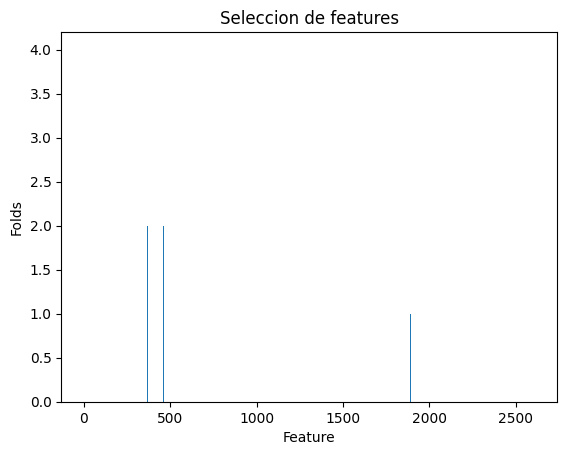

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest

# Definamos la matriz X
X = X_train.copy() # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = y_train.copy() # Nuestra etiqueta sigue siende la misma de antes

X = np.concatenate((X, X**2,X**3), axis=1) # agrego features elevados a potencias 

Kbest = 10 # los mejores K que voy a retener

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values_fs =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
selected_features= np.array([]).reshape(0,X.shape[1]) # aca es donde van a ir a parar los AUCs de cada fold. El reshape es para poder concatenar luego.


for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
    selector.fit(X_train, y_train) # encuentro los F scores 
    X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
    X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
    features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

    selected_features =  np.concatenate((selected_features,features),axis=0)

    regLog = LogisticRegression(max_iter=5000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


    probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values_fs.append(auc_test)

print('El AUC promedio es:')
print(np.mean(auc_values_fs))


import matplotlib.pyplot as plt

plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Seleccion de features')
plt.xlabel('Feature')
plt.ylabel('Folds')

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Definamos la matriz X
X = X_train.copy() # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = y_train.copy() # Nuestra etiqueta sigue siende la misma de antes

X_test = X_test.copy() # En este caso no hace falta reshapear, porque ya tiene la forma que queremos


scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test) 
X = scaler.transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression( max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)


print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[1.0, 0.6, 0.8, 0.9333333333333333, 0.5]
Estos es el promedio de todos los AUC:
0.7666666666666668


In [23]:
from numpy.random import shuffle # para shufflear el vector
from sklearn.preprocessing import MinMaxScaler # para escalar los datos

scaler = MinMaxScaler()
# Definamos la matriz X
X = X_train.copy() # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = y_train.copy() # Nuestra etiqueta sigue siende la misma de antes
scaler = MinMaxScaler() # escaleo por separado ambos sets

scaler.fit(X_test) 
X = scaler.transform(X)

y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)


print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Estos son los valores AUC para cada fold:
[0.4166666666666667, 0.4583333333333333, 0.5, 0.875, 0.75]
Estos es el promedio de todos los AUC:
0.6


c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


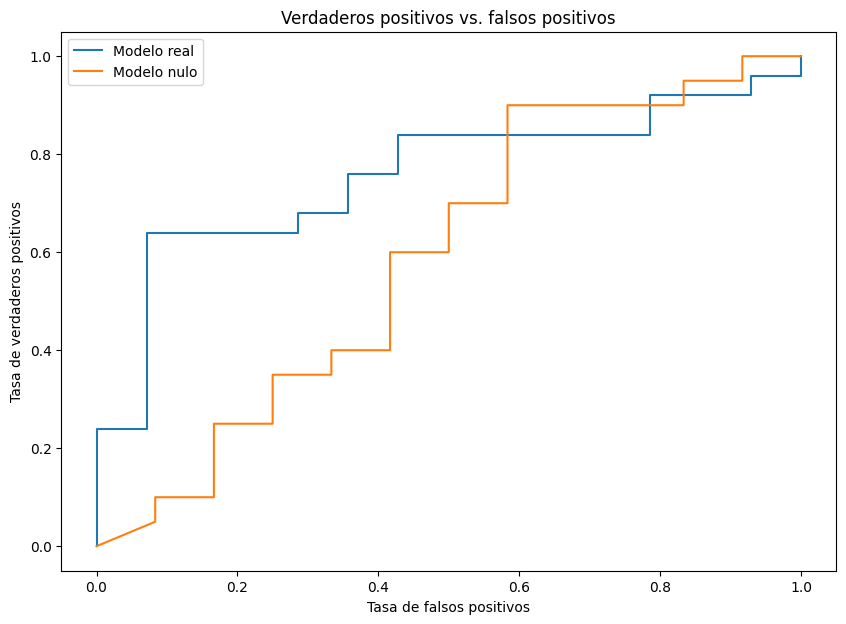

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

In [25]:
from sklearn.model_selection import permutation_test_score

regLog = LogisticRegression( max_iter=30000) # creamos un objeto clasificador
skf = StratifiedKFold(n_splits=5, shuffle=True) # creamos un objeto de cross-validation

AUC, AUC_shuffled, pvalue = permutation_test_score(regLog, X, y, scoring="roc_auc", cv=skf, n_permutations=100) # aca aplico la funcion 
# Notar que la función de arriba recibe como argumentos el clasificador (regLog) y la forma de hacer validación cruzada (skf), 
# además de los datos y el número de permutaciones que hacemos para construir nuestro modelo al azar.

print('Sin shufflear:')
print(AUC)
print('Modelo nulo (shuffleando):')
print(AUC_shuffled)
print('p-valor:')
print(pvalue)

c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Sin shufflear:
0.5666666666666667
Modelo nulo (shuffleando):
[0.46666667 0.6        0.46666667 0.38333333 0.38333333 0.51666667
 0.625      0.68333333 0.41666667 0.39166667 0.49166667 0.60833333
 0.60833333 0.29166667 0.48333333 0.18333333 0.60833333 0.55
 0.45       0.2        0.39166667 0.34166667 0.45       0.50833333
 0.66666667 0.50833333 0.375      0.69166667 0.375      0.51666667
 0.41666667 0.4        0.49166667 0.43333333 0.61666667 0.35833333
 0.60833333 0.55833333 0.53333333 0.425      0.575      0.68333333
 0.34166667 0.43333333 0.59166667 0.51666667 0.76666667 0.48333333
 0.50833333 0.4        0.425      0.68333333 0.4        0.45833333
 0.50833333 0.225      0.63333333 0.45833333 0.40833333 0.75
 0.5        0.50833333 0.61666667 0.55833333 0.71666667 0.53333333
 0.58333333 0.61666667 0.21666667 0.575      0.28333333 0.55833333
 0.21666667 0.3        0.50833333 0.525      0.38333333 0.40833333
 0.26666667 0.55833333 0.58333333 0.675      0.65833333 0.73333333
 0.43333333 0

c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

Text(0, 0.5, 'Probabilidad')

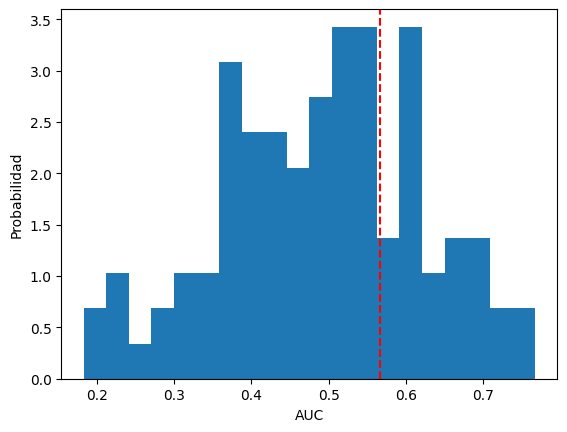

In [26]:
fig, ax = plt.subplots()

ax.hist(AUC_shuffled, bins=20, density=True) # armo el histograma de valores, normalizado para tener la probabilidad
ax.axvline(AUC, ls='--', color='r') # una linea vertical para indicar el AUC sin shufflear (modelo real)
ax.set_xlabel("AUC") # nombre de eje x
ax.set_ylabel("Probabilidad") # nombre de eje y

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar

# Definamos la matriz X
X = X_train.copy() # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = y_train.copy() # Nuestra etiqueta sigue siende la misma de antes
scaler = MinMaxScaler() # escaleo por separado ambos sets

scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
probas = regLog.predict_proba(X)  # este es el metodo para obtener las predicciones de probabilidades en base a la matriz features
print(probas)

[[9.99999999e-01 1.01837419e-09]
 [9.99987963e-01 1.20372520e-05]
 [9.99999991e-01 9.18687118e-09]
 [9.99971599e-01 2.84011378e-05]
 [3.91126534e-06 9.99996089e-01]
 [9.99988813e-01 1.11867775e-05]
 [1.01461307e-05 9.99989854e-01]
 [2.63239896e-05 9.99973676e-01]
 [1.90542861e-05 9.99980946e-01]
 [1.58864920e-07 9.99999841e-01]
 [7.69164898e-07 9.99999231e-01]
 [1.64976819e-05 9.99983502e-01]
 [3.93904509e-06 9.99996061e-01]
 [1.05547326e-05 9.99989445e-01]
 [9.99990392e-01 9.60796317e-06]
 [3.83710805e-05 9.99961629e-01]
 [9.99991193e-01 8.80695948e-06]
 [1.37684465e-05 9.99986232e-01]
 [8.49063625e-06 9.99991509e-01]
 [9.99998858e-01 1.14213337e-06]
 [4.53963331e-05 9.99954604e-01]
 [9.99990890e-01 9.10962749e-06]
 [6.84822556e-06 9.99993152e-01]
 [1.27205596e-05 9.99987279e-01]
 [4.68240632e-07 9.99999532e-01]
 [9.99941632e-01 5.83676816e-05]]


c:\hcgalvan\Repositorios\hcgalvan_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [28]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt # Para gráficos

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  


Matriz de confusion del modelo es:
[[10  0]
 [ 0 16]]
Tasa de verdaderos positivos: 1.0
Tasa de falsos positivos: 0.0


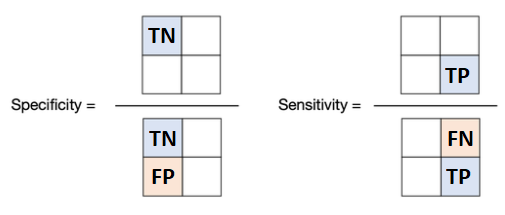

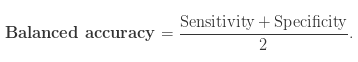

In [29]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]
cm = confusion_matrix(ypred, y) 
metricas = balanced_accuracy(cm)
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

Matriz de confusion del modelo es:
[[10  0]
 [ 0 16]]
Sensibilidad del modelo es de: 1.0
Especificidad del modelo es de: 1.0
BA del modelo es de: 1.0
